# Задание взято с [платформы](https://karpov.courses/)
## Проект e-learning: вариант 2
Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов) 

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (15 баллов) 

6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.  (23 балла)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникального идентификатора курса.

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

Файлы: 

[assessments.csv](https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ) — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
- `code_module` — идентификационный код предмета.

- `code_presentation` — семестр (Идентификационный код).

- `id_assessment` — тест (Идентификационный номер ассессмента).

- `assessment_type` — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

- `date` — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

- `weight` — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

[courses.csv](https://disk.yandex.ru/d/jmJxR8yhwCXlaw) — файл содержит список предметов по семестрам.
- `code_module` — предмет (идентификационный код).

- `code_presentation` — семестр (идентификационный код).

- `module_presentation_length` — продолжительность семестра в днях.

[studentAssessment.csv](https://disk.yandex.ru/d/DYd4M5b_8RETsA) — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
- `id_assessment` — тест (идентификационный номер).

- `id_student` — идентификационный номер студента.

- `date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

- `is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

- `score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

[studentRegistration.csv](https://disk.yandex.ru/d/lqHnH8NOZ458iw) — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.
- `code_module` — предмет (идентификационный код).

- `code_presentation` — семестр (идентификационный код)

- `id_student` — идентификационный номер студента.

- `date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

- `date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

Импортируем необходимые библиотеки

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
import json
import re

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [146]:
#функция для парсинга данных по ссылке с яндекс диска
def parse_data(base_url, public_key):
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return pd.read_csv(download_url)

Скачиваем необходимые данные

In [147]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
assessments_url = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
courses_url = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
studentAssessment_url = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
studentRegistration_url = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'

In [148]:
assessments = parse_data(base_url, assessments_url)
courses = parse_data(base_url, courses_url)
studentAssessment = parse_data(base_url, studentAssessment_url)
studentRegistration = parse_data(base_url, studentRegistration_url)

Смотрим на данные, пропущенные значение и где эти пропущенные значения

In [149]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [150]:
assessments.shape

(206, 6)

In [151]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [152]:
assessments[assessments['date'].isna() == True]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [153]:
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


In [154]:
courses.shape

(22, 3)

In [155]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [156]:
studentAssessment

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


In [157]:
studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [158]:
studentAssessment[studentAssessment.score.isna() == True]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


In [159]:
studentRegistration

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0


In [160]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [161]:
studentRegistration[studentRegistration.date_registration.isna() == True]

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0
5573,BBB,2014B,614270,NaN,-142.0
6295,BBB,2014B,2409808,NaN,-109.0
6305,BBB,2014B,2439442,NaN,-149.0
8307,BBB,2014J,694001,NaN,-36.0
8975,CCC,2014B,394791,NaN,-61.0


Чтобы ответить на вопрос, что будем считать курсом, необходимо посмотреть сколько всего есть предметов. В `courses.csv` их было 22, тогда как `assessments.csv` содержится 24 экзамена.


In [162]:
assessments[assessments.assessment_type == 'Exam'].style.apply(lambda x: ['background: green' if x.name in [62,63, 72, 73] 
                              else '' for i in x], 
                   axis=1)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,nan,100.000000
11,AAA,2014J,1763,Exam,nan,100.000000
23,BBB,2013B,14990,Exam,nan,100.000000
35,BBB,2013J,15002,Exam,nan,100.000000
47,BBB,2014B,15014,Exam,nan,100.000000
53,BBB,2014J,15025,Exam,nan,100.000000
62,CCC,2014B,24290,Exam,nan,100.000000
63,CCC,2014B,40087,Exam,nan,100.000000
72,CCC,2014J,24299,Exam,nan,100.000000
73,CCC,2014J,40088,Exam,nan,100.000000


Это из-за того, что `CCC` встречается в `courses.csv` 2 раза, а в `assessments.csv` 4 раза. Но если посмотреть сколько было совершено попыток студентов сдать эти модули, то выявится интересная вещь.


In [163]:
studentAssessment.query('id_assessment == 24290 |id_assessment == 24299') \
    .sort_values('id_student', ascending=False)

,id_assessment,id_student,date_submitted,is_banked,score
53369,24290,2697181,230,0,80.0
53368,24290,2692327,234,0,88.0
64811,24299,2691861,248,0,38.0
64810,24299,2691267,244,0,82.0
53367,24290,2686578,237,0,94.0
...,...,...,...,...,...
64816,24299,29639,248,0,74.0
64815,24299,29420,244,0,62.0
64814,24299,28787,243,0,44.0
64813,24299,27116,243,0,96.0


In [164]:
studentAssessment.query('id_assessment == 40087 | id_assessment == 40088') 

,id_assessment,id_student,date_submitted,is_banked,score


А именно, что `id_assessment=40087` и `id_assessment=40088` студенты ни разу не сдавали.

### Что будем считать курсом
Курсом будем считать уникальный `code_module` в совокупностью с семестром `code_presentation`. К примеру: (AAA 2013J), (CCC 2014B), (CCC 2014J)

### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

Зачетом на экзамене считают больше 40 баллов за экзамен. Для того, чтобы определить сколько людей сдали только один курс, необходимо найти сколько людей сдавали экзамен и сдали больше, чем на 40 баллов.

In [165]:
exam = pd.merge(assessments[assessments.assessment_type == 'Exam'], studentAssessment, how="inner", on='id_assessment')
exam['course'] =  exam.code_presentation + '_' + exam.code_module
exam.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,course
0,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0,2014B_CCC
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0,2014B_CCC
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0,2014B_CCC
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0,2014B_CCC
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0,2014B_CCC


In [166]:
exam[exam.score >= 40].groupby('id_student', as_index=False) \
    .agg({'course': 'count'}) \
    .query('course == 1') \
    .rename(columns={'course': 'count'})

,id_student,count
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4092,2694886,1
4093,2694933,1
4094,2695608,1
4095,2697181,1


И того, всего один курс сдали 3802 человек

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)

Сначала определим сложность экзаменов.

In [167]:
exam_difficulties = pd.DataFrame()

exam_difficulties = exam_difficulties.assign(
    course = exam[exam.score >= 40].groupby('course', as_index=False) \
    .agg({'code_module': 'count'}) \
    .sort_values('course')['course'],
          percent = exam[exam.score >= 40].groupby('course', as_index=False) \
    .agg({'code_module': 'count'}) \
    .sort_values('course')['code_module']*100/exam.groupby('course', as_index=False) \
    .agg({'code_module': 'count'}) \
    .sort_values('course')['code_module']
    ) \
    .sort_values('percent')

In [168]:
exam_difficulties

,course,percent
0,2013B_DDD,83.720930
4,2014J_CCC,87.243151
5,2014J_DDD,88.631579
2,2014B_CCC,88.888889
1,2013J_DDD,90.702479
3,2014B_DDD,92.557252


Самый простой экзамен `2014B_DDD`, а самый сложный - `2013B_DDD`

А теперь определим сложность курсов.

In [169]:
studentRegistration['course'] =  studentRegistration.code_presentation + '_' + studentRegistration.code_module
studentRegistration

,code_module,code_presentation,id_student,date_registration,date_unregistration,course
0,AAA,2013J,11391,-159.0,NaN,2013J_AAA
1,AAA,2013J,28400,-53.0,NaN,2013J_AAA
2,AAA,2013J,30268,-92.0,12.0,2013J_AAA
3,AAA,2013J,31604,-52.0,NaN,2013J_AAA
4,AAA,2013J,32885,-176.0,NaN,2013J_AAA
...,...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN,2014J_GGG
32589,GGG,2014J,2645731,-23.0,NaN,2014J_GGG
32590,GGG,2014J,2648187,-129.0,NaN,2014J_GGG
32591,GGG,2014J,2679821,-49.0,101.0,2014J_GGG


In [170]:
course_difficulties = pd.DataFrame()

course_difficulties = course_difficulties.assign(
    course = studentRegistration.groupby('course', as_index=False) \
    .agg({'code_module': 'count'}) \
    .sort_values('course')['course'],
          percent = studentRegistration[studentRegistration.date_unregistration.isna() == True].groupby('course', as_index=False) \
    .agg({'code_module': 'count'}) \
    .sort_values('course')['code_module']*100/studentRegistration.groupby('course', as_index=False) \
    .agg({'code_module': 'count'}) \
    .sort_values('course')['code_module']
    ) \
    .sort_values('percent')

In [171]:
course_difficulties

,course,percent
10,2014B_CCC,53.615702
17,2014J_CCC,58.006405
11,2014B_DDD,60.179153
5,2013J_DDD,64.705882
20,2014J_FFF,64.862579
18,2014J_DDD,65.002773
1,2013B_DDD,66.922487
16,2014J_BBB,67.888307
13,2014B_FFF,69.266667
9,2014B_BBB,69.683819


Самый простой курс - `2013J_GGG`, а самый трудный - `2014B_CCC`

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов)

В этой задаче будем анализировать именно предметы (`code_module`)

In [172]:
exam.query('score >= 40') \
    .groupby(['code_module','id_student', 'id_assessment'], as_index=False) \
    .agg({'date_submitted': 'max'}) \
    .groupby('code_module', as_index=False) \
    .agg({'date_submitted': 'mean'})

,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.976006


### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)


В этой задаче будем анализировать именно предметы (`code_module`)

In [173]:
studentRegistration.groupby('code_module', as_index=False) \
    .agg({'date_registration': 'count'}) \
    .sort_values('date_registration', ascending=False) \
    .rename(columns={'date_registration': 'count_of_registration'}) 

,code_module,count_of_registration
1,BBB,7900
5,FFF,7751
3,DDD,6257
2,CCC,4426
4,EEE,2932
6,GGG,2534
0,AAA,748


In [174]:
studentRegistration[studentRegistration['date_unregistration'].isna() == False] \
    .groupby('code_module', as_index=False) \
    .agg({'date_registration': 'count'}) \
    .sort_values('date_registration', ascending=False) \
    .rename(columns={'date_registration': 'count_of_unregistration'}) 

,code_module,count_of_unregistration
5,FFF,2370
1,BBB,2369
3,DDD,2223
2,CCC,1940
4,EEE,716
6,GGG,289
0,AAA,126


Для задачи также определим отток в процентах.

In [175]:
outflow_module = pd.DataFrame()

outflow_module.assign(
            code_module = studentRegistration[studentRegistration['date_unregistration'].isna() == False] \
        .groupby('code_module', as_index=False) \
        .agg({'date_registration': 'count'}) \
        .sort_values('code_module')['code_module'],
            percent = studentRegistration[studentRegistration['date_unregistration'].isna() == False] \
        .groupby('code_module', as_index=False) \
        .agg({'date_registration': 'count'}) \
        .rename(columns={'date_registration': 'count_of_unregistration'}) \
        .sort_values('code_module')['count_of_unregistration']*100/studentRegistration.groupby('code_module', as_index=False) \
        .agg({'date_registration': 'count'}) \
        .rename(columns={'date_registration': 'count_of_registration'}) \
        .sort_values('code_module')['count_of_registration']
    ) \
    .sort_values('percent', ascending=False) \
    .head(3)

,code_module,percent
2,CCC,43.831902
3,DDD,35.528208
5,FFF,30.576700


### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. (15 баллов)


У нас имеется 4 семестра 2014B, 2014J, 2013B, 2013J, при этом по двум модулям люди сдавали экзамены (CCC и DDD), а по всем остальным нет. 

Для ответа на первый вопрос посчитаем количество студентов в процентах, которые не дошли курс до конца (`date_unregistration` != NaN). 

Для второго вопроса посчитаем отдельно среднее время сдачи для курсов с экзаменами и без экзамена, затем объединим в один датафрейм и посчитаем окончательно среднее время сдачи в каждом из семестров.

In [176]:
outflow_course = pd.DataFrame()

outflow_course.assign(
            code_module = studentRegistration \
        .groupby('code_presentation', as_index=False) \
        .agg({'date_registration': 'count'}) \
        .sort_values('code_presentation')['code_presentation'],
            percent = studentRegistration[studentRegistration['date_unregistration'].isna() == False] \
        .groupby('code_presentation', as_index=False) \
        .agg({'date_registration': 'count'}) \
        .rename(columns={'date_registration': 'count_of_unregistration'}) \
        .sort_values('code_presentation')['count_of_unregistration']*100/studentRegistration.groupby('code_presentation', as_index=False) \
        .agg({'date_registration': 'count'}) \
        .rename(columns={'date_registration': 'count_of_registration'}) \
        .sort_values('code_presentation')['count_of_registration']
    ) \
    .sort_values('percent', ascending=False)
    

,code_module,percent
2,2014B,33.303365
3,2014J,33.161497
0,2013B,28.721129
1,2013J,26.779853


То есть максимальный отток наблюдается в семестре 2014B

In [177]:
data = pd.merge(assessments, studentAssessment, how="inner", on='id_assessment')
data = data.query('code_module != "CCC" & code_module != "DDD"') 

data['course'] =  data.code_presentation + '_' + data.code_module
grouped_data = data.groupby('id_student', as_index=False) \
    .agg({'id_assessment': 'max', 'date_submitted': 'max', 'code_presentation': 'max'})[['id_student', 'date_submitted', 'code_presentation']]
grouped_data

,id_student,date_submitted,code_presentation
0,6516,210,2014J
1,11391,212,2013J
2,23629,95,2013B
3,23798,210,2013J
4,24186,207,2014B
...,...,...,...
16996,2698125,227,2013J
16997,2698257,215,2013J
16998,2698535,171,2013J
16999,2698577,201,2014J


In [178]:
cont_courses = pd.concat([grouped_data, exam.query('score >= 40') \
    .groupby('id_student', as_index=False) \
    .agg({'date_submitted': 'max', 'code_presentation': 'max'})], ignore_index=True)
cont_courses

,id_student,date_submitted,code_presentation
0,6516,210,2014J
1,11391,212,2013J
2,23629,95,2013B
3,23798,210,2013J
4,24186,207,2014B
...,...,...,...
21093,2694886,236,2014B
21094,2694933,230,2013B
21095,2695608,237,2013J
21096,2697181,230,2014B


In [179]:
cont_courses.groupby('code_presentation', as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .sort_values('date_submitted', ascending=False)

,code_presentation,date_submitted
3,2014J,188.083242
1,2013J,180.610563
2,2014B,179.310694
0,2013B,171.699411


Самое большое время сдачи наблюдается в 2014J семестре.

### 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Определим метрику $R$. В данном случае это время сдачи экзаменов. Для этого посчитаем среднее время сдачи экзамена и стандартное отклонение. По $R$ будет 3 кластера. Первый, кто сдает экзамены раньше, чем mean-std, второй -- от mean-std до mean+std и третий, кто сдает от mean+std

In [180]:
def r_score(date, mean, std):
    if date < mean-std:
        return 1
    if date > mean-std and date < mean+std:
        return 2
    if date > mean+std:
        return 3

In [181]:
exam_date_mean, exam_date_std = exam.query('score >= 40') \
    .groupby(['code_module','id_student', 'id_assessment'], as_index=False) \
    .agg({'date_submitted': 'max'})['date_submitted'].mean(), exam.query('score >= 40') \
    .groupby(['code_module','id_student', 'id_assessment'], as_index=False) \
    .agg({'date_submitted': 'max'})['date_submitted'].std()

exam_date_mean, exam_date_std

(238.50068306010928, 5.696651018686289)

In [182]:
students_exam_dates = exam.query('score >= 40') \
    .groupby(['code_module','id_student', 'id_assessment'], as_index=False) \
    .agg({'date_submitted': 'max'}) \
    .groupby('id_student', as_index=False) \
    .agg({'date_submitted': 'mean'})

In [183]:
students_exam_dates['R'] = students_exam_dates.date_submitted.apply(lambda x: r_score(x, exam_date_mean, exam_date_std))
students_exam_dates.head()

,id_student,date_submitted,R
0,23698,243.0,2
1,24213,236.0,2
2,27116,243.0,2
3,28046,237.0,2
4,28787,243.0,2


$F$ оценка. Определим дл 4097 студентов (которые успешно сдавали экзамены) процент успешной сдачи курса, на которые они записались.

In [184]:
students_reg = pd.DataFrame(studentRegistration.merge(students_exam_dates, how='inner', on='id_student').dropna(subset=['date_registration']).groupby('id_student', as_index=False) \
    .agg({'date_unregistration': 'count'})['id_student'])

students_reg['percent'] = (1-studentRegistration.merge(students_exam_dates, how='inner', on='id_student').dropna(subset=['date_registration']).groupby('id_student', as_index=False) \
    .agg({'date_unregistration': 'count'})['date_unregistration']/studentRegistration.merge(students_exam_dates, how='inner', on='id_student').dropna(subset=['date_registration']).groupby('id_student', as_index=False) \
    .agg({'date_registration': 'count'})['date_registration'])

students_reg['percent'].mean(), students_reg['percent'].std()

(0.9608860141567, 0.13485463836856162)

In [185]:
students_reg.percent.unique()

array([1.        , 0.5       , 0.66666667, 0.25      , 0.33333333])

При этом также разделим на 3 кластера, но в данном случае будем использовать другое деление, так как процент законченности курсов достаточно велик. Первый кластер -- от 100% до 67%, второй класер от 67% до 50% и третий от 50% до 0.

In [186]:
def f_score(percent):
    if percent > 0.67:
        return 1
    if percent > 0.5 and percent < 0.67:
        return 2
    if percent <= 0.5:
        return 3

In [187]:
students_reg["F"] = students_reg.percent.apply(lambda x: f_score(x)) 
students_reg.head()

,id_student,percent,F
0,23698,1.0,1
1,24213,0.5,3
2,27116,1.0,1
3,28046,1.0,1
4,28787,1.0,1


Определим метрику $M$. В данном случае это оценка за экзамен. Для этого посчитаем среднюю оценку за экзамен  и стандартное отклонение. По $M$ будет 3 кластера. Первый, кто сдает экзамены на  mean+std, второй -- от mean-std до mean+std и третий, кто сдает от mean-std

In [188]:
def m_score(score, mean, std):
    if score > mean+std:
        return 1
    if score > mean-std and score < mean+std:
        return 2
    if score < mean-std:
        return 3

In [189]:
exam_score_mean, exam_score_std = exam.query('score >= 40').groupby('id_student', as_index=False) \
    .agg({'score': 'mean'})['score'].mean(), exam.query('score >= 40').groupby('id_student', as_index=False) \
    .agg({'score': 'mean'})['score'].std()

In [190]:
students_exam_scores = exam.query('score >= 40').groupby('id_student', as_index=False) \
    .agg({'score': 'mean'})

In [191]:
students_exam_scores['M'] = students_exam_scores.score.apply(lambda x: m_score(x, exam_score_mean, exam_score_std))
students_exam_scores.head()

,id_student,score,M
0,23698,80.0,2
1,24213,58.0,2
2,27116,96.0,1
3,28046,40.0,3
4,28787,44.0,3


Теперь объединим три датафрейма в один с кластеризацией для каждого студента.

In [192]:
RFM_clusters = students_exam_scores[['id_student']]
RFM_clusters['R'] = students_exam_dates.R
RFM_clusters['F'] = students_reg.F
RFM_clusters['M'] = students_exam_scores.M

RFM_clusters['RFM_score'] = students_exam_dates.R.map(str) + students_reg.F.map(str) + students_exam_scores.M.map(str)
RFM_clusters.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_student,R,F,M,RFM_score
0,23698,2,1,2,212
1,24213,2,3,2,232
2,27116,2,1,1,211
3,28046,2,1,3,213
4,28787,2,1,3,213


In [194]:
df_plot = (RFM_clusters.R.value_counts(normalize=True)*100).reset_index().rename(columns={'R': 'score'})
df_plot['cluster'] = 'R'
df_plot1 = (RFM_clusters.F.value_counts(normalize=True)*100).reset_index().rename(columns={'F': 'score'})
df_plot1['cluster'] = 'F'
df_plot2 = (RFM_clusters.M.value_counts(normalize=True)*100).reset_index().rename(columns={'M': 'score'})
df_plot2['cluster'] = 'M'
dplot = pd.concat([df_plot, df_plot1, df_plot2])

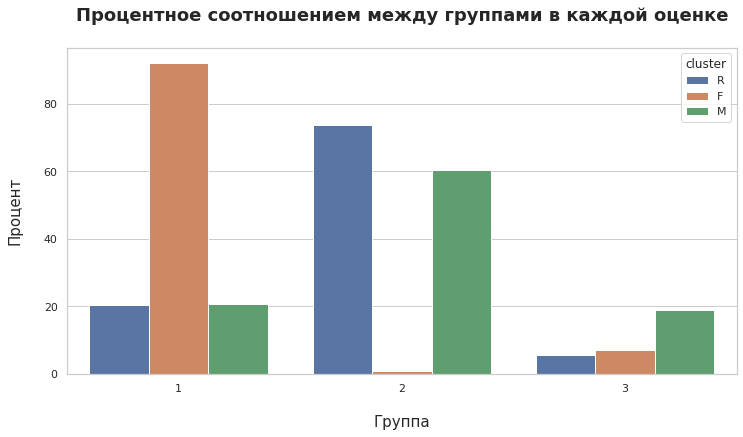

In [195]:
ax = sns.barplot(data=dplot, x='index', y='score', hue='cluster')
ax.set_title('Процентное соотношением между группами в каждой оценке\n', fontsize = 18, fontweight='bold' )
ax.set_xlabel('\nГруппа', fontsize = 15)
ax.set_ylabel('Процент\n', fontsize = 15);

Теперь осталось только переместить всех учеников по кластерам, по алгоритму, который представлен ниже.

In [196]:
def clustering(x):
    if x == '111':
        return 'Гений'
    if len(re.findall('2', x)) < 3 and len(re.findall('3', x)) == 0:
        return 'Умный'
    if x == '222' or len(re.findall('3', x)) == 1:
        return 'Средний ученик'
    if len(re.findall('3', x)) < 3:
        return 'Нужна небольшая помощь'
    if x == '333':
        return 'Нужна помощь'

In [197]:
RFM_clusters['cluster'] = RFM_clusters.RFM_score.apply(lambda x: clustering(x))
RFM_clusters.head()

,id_student,R,F,M,RFM_score,cluster
0,23698,2,1,2,212,Умный
1,24213,2,3,2,232,Средний ученик
2,27116,2,1,1,211,Умный
3,28046,2,1,3,213,Средний ученик
4,28787,2,1,3,213,Средний ученик


Посмотрим также, не пропустили ли мы кого-то при кластеризации

In [198]:
RFM_clusters.isna().sum()

id_student    0
R             0
F             0
M             0
RFM_score     0
cluster       0
dtype: int64

In [199]:
dplot = RFM_clusters.cluster.value_counts() \
    .reindex(['Гений', 'Умный', 'Средний ученик', 'Нужна небольшая помощь', 'Нужна помощь']).reset_index()

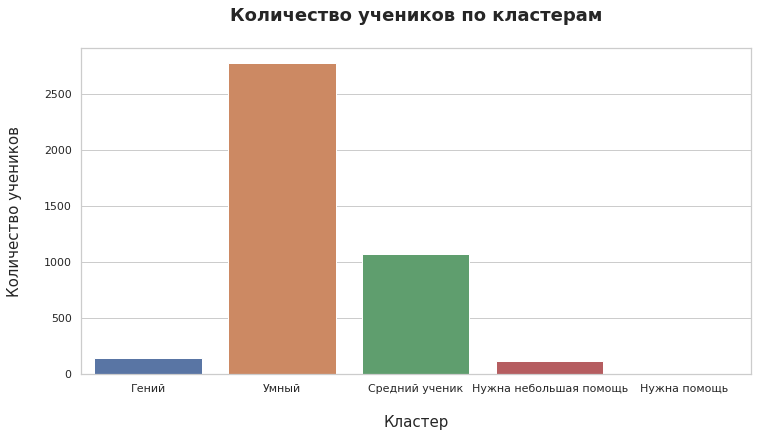

In [200]:
ax = sns.barplot(data=dplot, x='index', y='cluster')
ax.set_title('Количество учеников по кластерам\n', fontsize = 18, fontweight='bold' )
ax.set_xlabel('\nКластер', fontsize = 15)
ax.set_ylabel('Количество учеников\n', fontsize = 15);